<a href="https://colab.research.google.com/github/manojmukkamala/VolcanoesOnVenus/blob/master/VenusDataCleansing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Set-Up

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
import pickle

%matplotlib inline

### Importing the Dataset

In [0]:
train_images = pd.read_csv("/content/drive/My Drive/VolcanoesOnVenus/Volcanoes_train/train_images.csv", header = None)

In [0]:
train_labels = pd.read_csv("/content/drive/My Drive/VolcanoesOnVenus/Volcanoes_train/train_labels.csv")

In [0]:
test_images = pd.read_csv("/content/drive/My Drive/VolcanoesOnVenus/Volcanoes_test/test_images.csv", header = None)

In [0]:
test_labels = pd.read_csv("/content/drive/My Drive/VolcanoesOnVenus/Volcanoes_test/test_labels.csv")

### Data Exploration

#### Raw Data

In [6]:
print("Training Data:", train_images.shape)
print("Testing Data:", test_images.shape)

Training Data: (7000, 12100)
Testing Data: (2734, 12100)


In [0]:
train_labels = train_labels['Volcano?'].rename(columns = {'Volcano?': 'Volcano'})
test_labels = test_labels['Volcano?'].rename(columns = {'Volcano?': 'Volcano'})

In [8]:
train_labels.value_counts()

0    6000
1    1000
dtype: int64

In [9]:
test_labels.value_counts()

0    2300
1     434
dtype: int64

In [16]:
df = train_images.join(pd.DataFrame(data = train_labels, columns = ['Volcano']))
df.head()

0    1    2    3   4    5  ...  12095  12096  12097  12098  12099  Volcano
0   95  101   99  103  95   86  ...     99    117    116    118     96        1
1   91   92   91   89  92   93  ...    105    104    100     90     81        0
2   87   70   72   74  84   78  ...     80     91     80     84     90        0
3    0    0    0    0   0    0  ...     90     92     80     88     96        0
4  114  118  124  119  95  118  ...    104    106    117    111    115        0

[5 rows x 12101 columns]

In [0]:
df.head()

#### Corrupted Images

The data that we are dealing with is image data. So, there is a good chance for data corruption.

It seems (also mentioned in data dictionary) that few records are corrupted. Take a look at the fourth record (index = 3) in the above sample dataframe. The record seems corrupted because it is having a bunch of 0's for the pixel values. 

Let's plot and see a few records and then we will build a work around to find and filter the corrupted records.

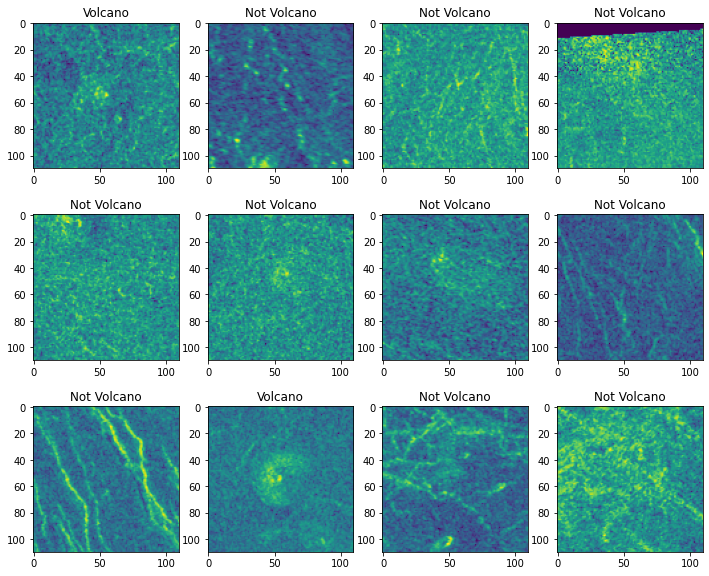

In [17]:
dfs = df.drop(columns = ["Volcano"])

plt.figure(figsize = (12, 10))

for i in range(0, 12):
    subplot(3, 4, i+1)
    plt.imshow(np.array(dfs.iloc[i]).reshape(110, 110))
    plt.title("Volcano" if df.iloc[i]["Volcano"] == 1 else "Not Volcano")

Observations:

- The fourth record has some data corrupted at the top of the image.

Let's look at the pixel value distributions for these images.

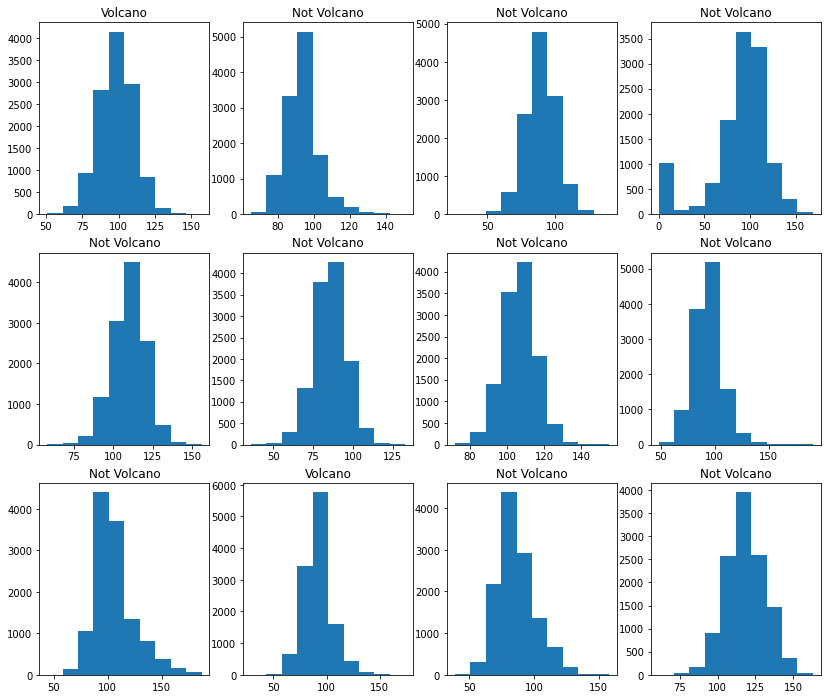

In [18]:
plt.figure(figsize = (14, 12))
for i in range(0, 12):
    subplot(3, 4, i+1)
    plt.hist(np.array(dfs.iloc[i]))
    plt.title("Volcano" if df.iloc[i]["Volcano"] == 1 else "Not Volcano")

Observations:

- According to the histogram, for the corrupted image, the number of pixels whose value is 0 are relatively high.

Let's calculate the number of dark pixels (pixel value = 0) per image. Then we will define a threshold to find and filter corrupted records.

In [0]:
df["DarkPxls"] = sum((dfs == 0), axis = 1)

Let's fetch the index of corrupted images. It is useful later.

In [0]:
crpt_id = df[df["DarkPxls"] != 0].index

Let's look at some of the corrupted images

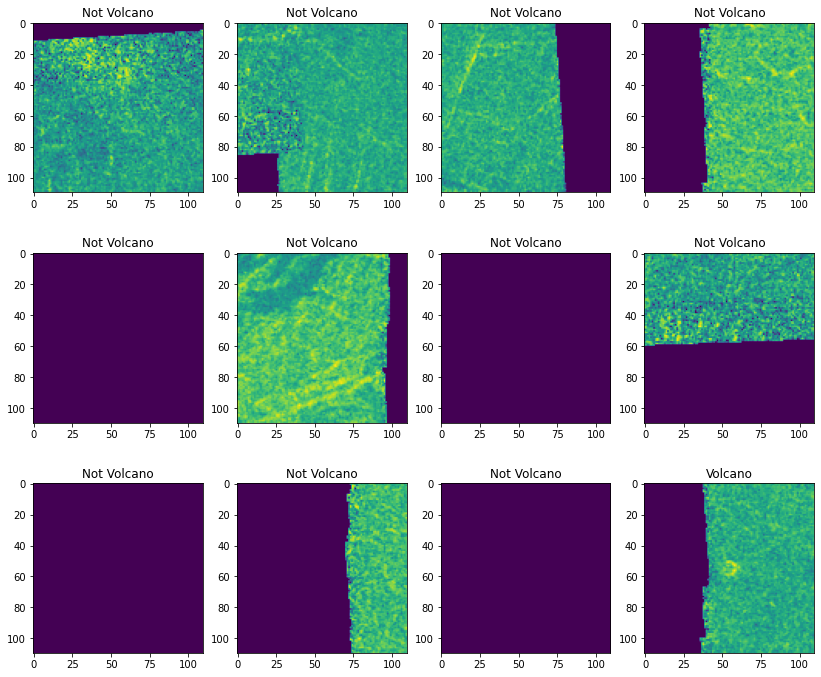

In [21]:
plt.figure(figsize = (14, 12))

for i in range(0, 12):
    subplot(3, 4, i+1)
    plt.imshow(np.array(dfs.loc[crpt_id].iloc[i]).reshape(110, 110))
    plt.title("Volcano" if df.loc[crpt_id].iloc[i]["Volcano"] == 1 else "Not Volcano")

#### Statistics and Distribution of Corrupted Pixels

##### Stats

In [22]:
for i, j in zip(df["DarkPxls"].loc[crpt_id].describe().index.values[1:], df["DarkPxls"].loc[crpt_id].describe().values[1:]):
    print(str(i).upper() + " of Corrupted Pixels " + str(round(j)), "\n")

MEAN of Corrupted Pixels 8190.0 

STD of Corrupted Pixels 4500.0 

MIN of Corrupted Pixels 1.0 

25% of Corrupted Pixels 4020.0 

50% of Corrupted Pixels 11198.0 

75% of Corrupted Pixels 12100.0 

MAX of Corrupted Pixels 12100.0 



##### Quartile Plot

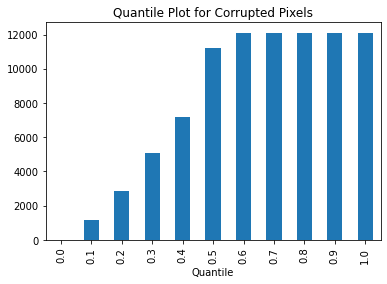

In [23]:
df["DarkPxls"].loc[crpt_id].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]).plot.bar()

plt.xlabel("Quantile")
plt.title("Quantile Plot for Corrupted Pixels")
plt.show()

Observations: 

- Almost 50% of the corrupted images have all the pixels corrupted.

- 25% of the corrupted images have around 4000 pixels corrupted.

- 10% of the corrupted images have around 2000 pixels corrupted.

##### Corrupted Pixels Distribution 

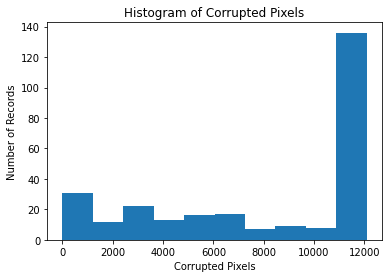

In [24]:
df["DarkPxls"].loc[crpt_id].plot.hist()

plt.title("Histogram of Corrupted Pixels")
plt.xlabel("Corrupted Pixels")
plt.ylabel("Number of Records")
plt.show()

According to the histogram, most of the corrupted images have lot of corrupted pixels.

Let's look at an example from each bin

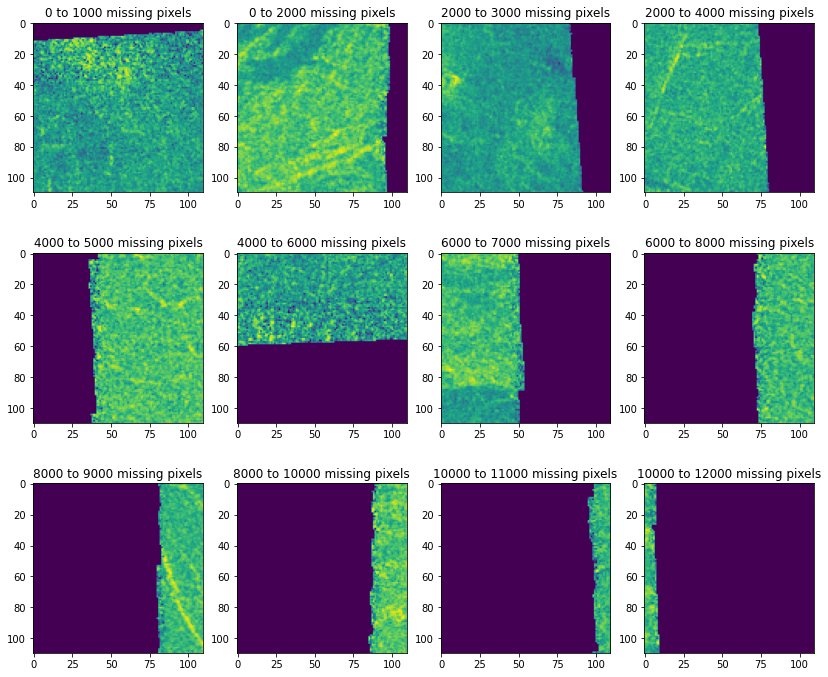

In [25]:
plt.figure(figsize = (14, 12))

for i in range(0, 12):
    subplot(3, 4, i+1)
    plt.imshow(np.array(df[(df['DarkPxls'] > 2000*(i/2)) & (df['DarkPxls'] <= 2000*(i+1)/2)].drop(['DarkPxls', 'Volcano'], axis = 1).iloc[0]).reshape(110, 110))
    plt.title('{0} to {1} missing pixels'.format(2000*(i//2), 2000*(i+1)//2))
    #plt.title("Volcano" if df[(df['DarkPxls'] > 2000*(i/2)) & (df['DarkPxls'] <= 2000*(i+1)/2)].iloc[0]["Volcano"] == 1 else "Not Volcano")

#### Target Classes in Corrupted Images

In [26]:
df.loc[crpt_id]["Volcano"].value_counts()

0    253
1     18
Name: Volcano, dtype: int64

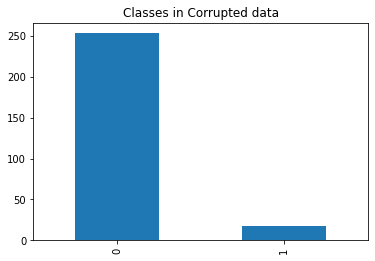

In [27]:
df.loc[crpt_id]["Volcano"].value_counts().plot.bar()

plt.title("Classes in Corrupted data")
plt.show()

Observations:

- Lot of corrupted images do not have volcanoes in them.
- Only a few corrupted records do have volcanoes.

#### Omitting Corrupted Images without Volcanoes

As our dataset already have a good number of examples without volcanoes, I think it would not be good idea to invest time to define threshold level for missing pixels or to impute data for corrupted pixels that have Volcanoes.

Let's omit the corrupted records.

In [0]:
df = df[~((df['Volcano'] == 0) & (df['DarkPxls'] > 0))]

#### Corrupted Images with Volcanoes

In [29]:
vol_crpt_id = df[((df['Volcano'] == 1) & (df['DarkPxls'] > 0))].index.values

df.loc[vol_crpt_id].head()

0    1    2    3    4  ...  12097  12098  12099  Volcano  DarkPxls
244     0    0    0    0    0  ...     82     94     97        1      4343
613     0    0    0    0    0  ...     84     80     84        1      4053
661     0    0    0    0    0  ...    106     89    100        1      3194
1413  122  120  102  114  120  ...    110    113    100        1        42
1851  113  104  105   96  105  ...      0      0      0        1      4227

[5 rows x 12102 columns]

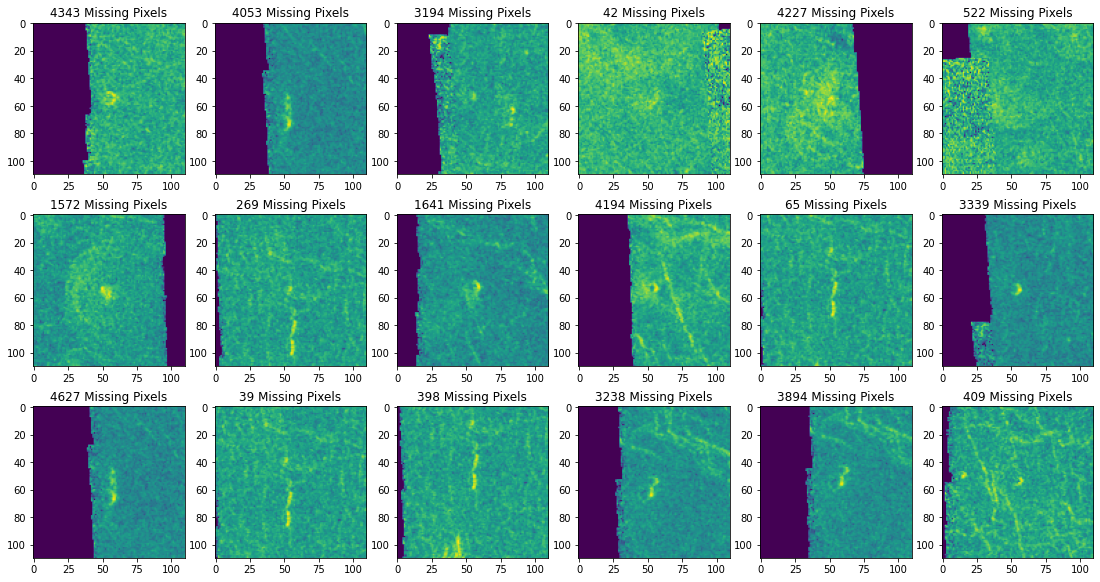

In [30]:
plt.figure(figsize = (19, 10))

j = 1
for i in vol_crpt_id[0:18]:
    subplot(3, 6, j)
    plt.imshow(np.array(dfs.loc[i]).reshape(110, 110))
    plt.title(str(df["DarkPxls"].loc[i]) + " Missing Pixels")
    j = j + 1

#### Imputing

As we already have a Class Imbalance (ver few images with Volcanoes) in the target variable on our original dataset, let's try not to remove the corrupted images that has volcanoes.

Instead let's fill the corrupted pixels in an image with the mean values of the corresponding image. 

But, should we use Row means or Column means?

It seems for most of the images the entire column is corrupted. So, let's use row means of image to replace the corrupted pixel.

In [0]:
dfs = np.array(df.drop(['Volcano', 'DarkPxls'], axis = 1).loc[vol_crpt_id]).reshape(-1, 110, 110)

for i in range(dfs.shape[0]):
    dfs[i] = np.array(pd.DataFrame(dfs[i]).T.replace(0, pd.DataFrame(dfs[i]).mean(axis = 1).apply(int)).T)

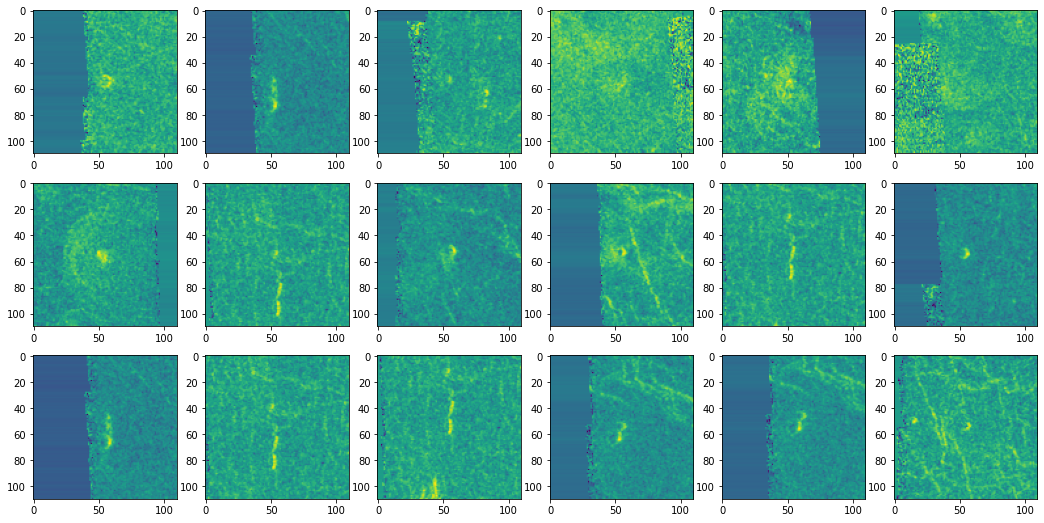

In [32]:
plt.figure(figsize = (18, 9))

for i in range(dfs.shape[0]):
    subplot(3, 6, i+1)
    plt.imshow(dfs[i])

The images doesn't look good. Row means doesn't seem like a great idea. 

Instead let's compute the mean of every pixel for all the images that are not corrupted and use those means to replace the corrupted pixels in corrupted images.

In [0]:
mean_row = pd.Series(df[df["DarkPxls"] == 0].drop(['Volcano', 'DarkPxls'], axis = 1).mean().apply(int)).T

In [34]:
vol_crpt_id

array([ 244,  613,  661, 1413, 1851, 2305, 2448, 3206, 3428, 3806, 3955,
       4332, 4681, 5557, 6251, 6325, 6379, 6697])

In [0]:
dfs = df.drop(['Volcano', 'DarkPxls'], axis = 1).loc[vol_crpt_id].replace(0, mean_row)

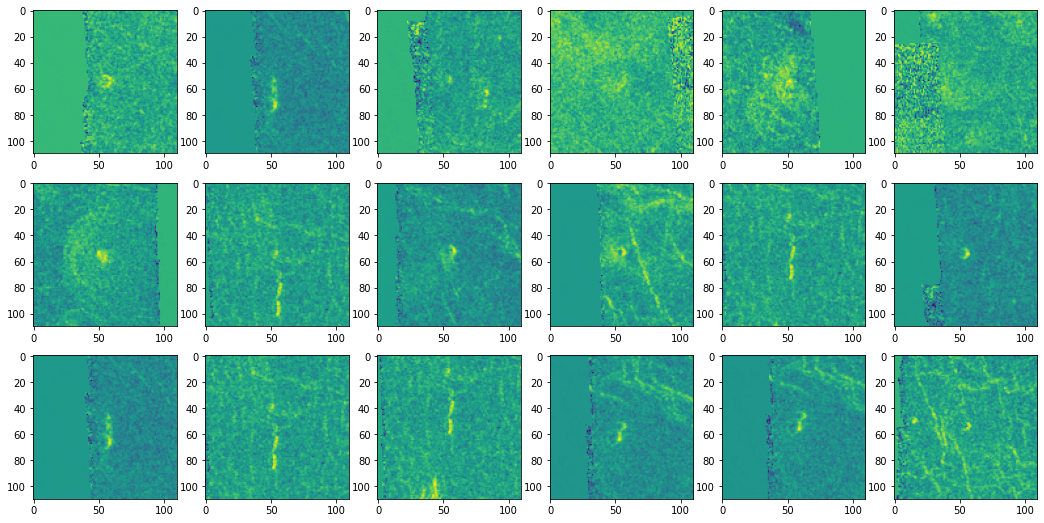

In [36]:
plt.figure(figsize = (18, 9))

j = 1
for i in vol_crpt_id[0:18]:
    subplot(3, 6, j)
    plt.imshow(np.array(dfs.loc[i]).reshape(110, 110))
    j = j + 1

Definitely not a wonderful improvement, but much better than using row means.

Now, in this final attempt, let's try to replace the missing/corrupted pixels by flipping the image (mirroring) and use the corresponding pixels from flipped image.

In [0]:
#dfs = df.drop(['Volcano', 'DarkPxls'], axis = 1)
for i in vol_crpt_id:
    zero_index = df.loc[i][df.loc[i] == 0].index
    flipped = pd.Series(np.flip(np.array(df.loc[i][:-2]).reshape(110, 110), axis = 1).ravel())[zero_index]
    df.loc[i][zero_index] = flipped

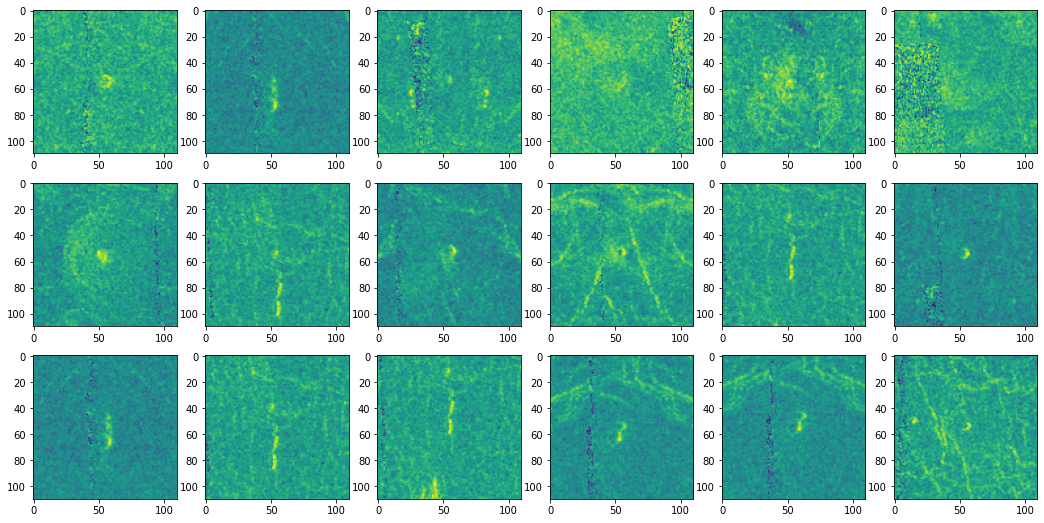

In [38]:
plt.figure(figsize = (18, 9))

j = 1
for i in vol_crpt_id[0:18]:
    subplot(3, 6, j)
    plt.imshow(np.array(df.loc[i][:-2]).reshape(110, 110))
    j = j + 1

Awesome, this looks much better than the above two methods. Let's stick with this!

In [0]:
df = df.reset_index().drop(['index', 'DarkPxls'], axis = 1)

### Data Preparation

#### Creating Train, Validation and Test sets

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train = df.drop("Volcano", axis = 1)
y_train = df["Volcano"]

X_val, X_test, y_val, y_test = train_test_split(test_images, test_labels, test_size = 0.2)

In [42]:
print("Training Samples:", X_train.shape[0])
print("Validation Samples:", X_val.shape[0])
print("Test Samples:", X_test.shape[0])

Training Samples: 6747
Validation Samples: 2187
Test Samples: 547


#### Target Classes

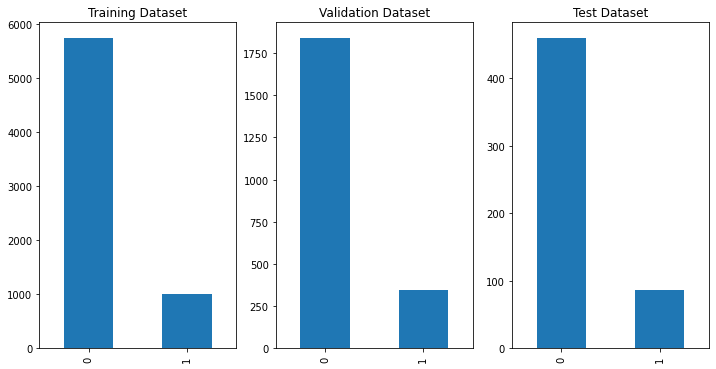

In [43]:
plt.figure(figsize = (12, 6))

subplot(1, 3, 1)
y_train.value_counts().plot.bar()
plt.title("Training Dataset")

subplot(1, 3, 2)
y_val.value_counts().plot.bar()
plt.title("Validation Dataset")

subplot(1, 3, 3)
y_test.value_counts().plot.bar()
plt.title("Test Dataset")

plt.show()

#### Normalize

It is a good practice to normalize data before feeding it to the learning algorithm. Algorithms like gradient decent will converge faster if we normalize/standardize the input data.

In [0]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

#### Sanity Checks

In [45]:
print("Number of Input Examples:", X_train.shape[0])
print("Number of Input Features:", X_train.shape[1], '\n')
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Number of Input Examples: 6747
Number of Input Features: 12100 

X_train shape: (6747, 12100)
y_train shape: (6747,)
X_val shape: (2187, 12100)
y_val shape: (2187,)
X_test shape: (547, 12100)
y_test shape: (547,)


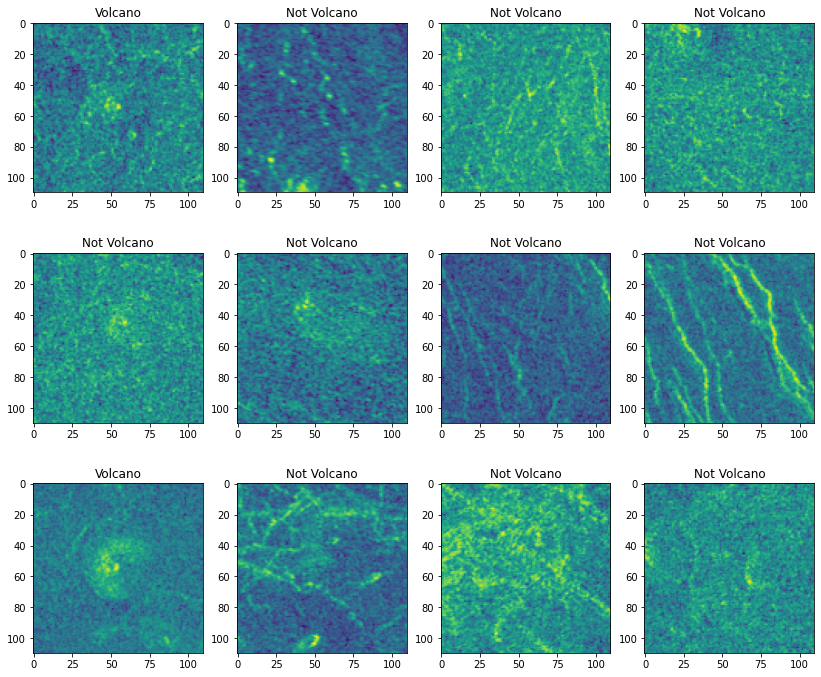

In [46]:
plt.figure(figsize = (14, 12))

for i in range(0, 12):
    subplot(3, 4, i+1)
    plt.imshow(np.array(X_train.iloc[i]).reshape(110, 110))
    plt.title("Volcano" if y_train[i] == 1 else "Not Volcano")

#### Save the Dataset

In [0]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

volcanoes_dataset = ((X_train, y_train), (X_val, y_val), (X_test, y_test))

In [0]:
pickle_out = open("volcanoes_dataset.pickle", "wb")
pickle.dump(volcanoes_dataset, pickle_out)
pickle_out.close()

### Analysis

In [0]:
pickle_in = open("/content/drive/My Drive/VolcanoesOnVenus/volcanoes_dataset.pickle", "rb")
volcanoes_dataset = pickle.load(pickle_in)
((X_train, y_train), (X_val, y_val), (X_test, y_test)) = volcanoes_dataset

In [51]:
X_train.shape

(6747, 12100)

In [52]:
y_train.shape

(6747,)

In [0]:
vol = X_train[y_train == 1]
non_vol = X_train[y_train == 0]

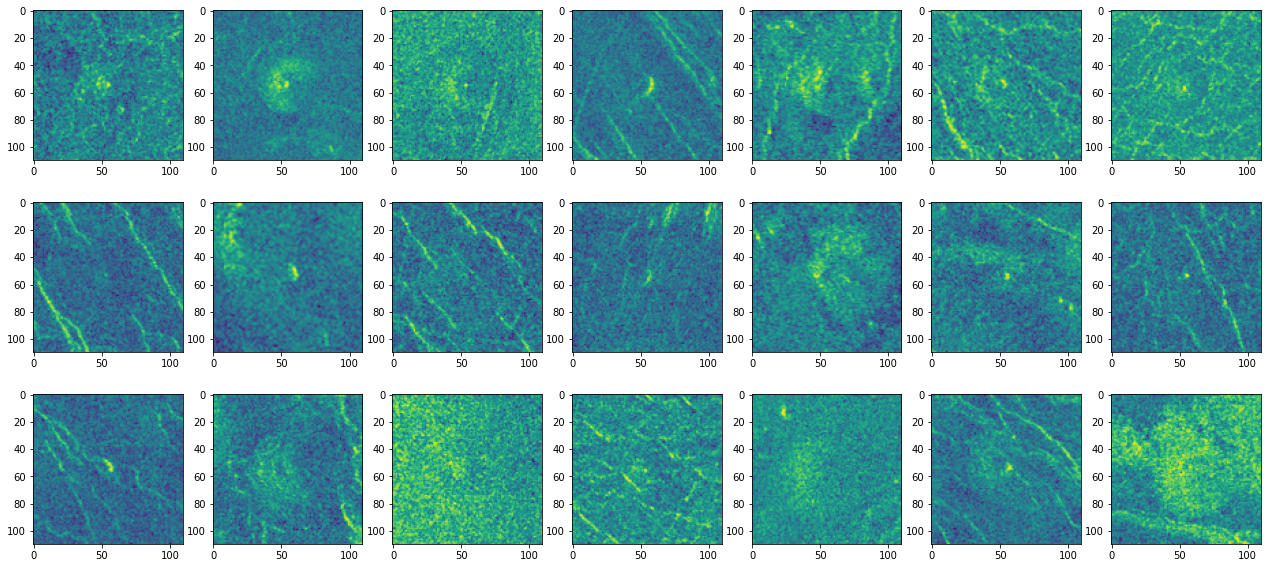

In [73]:
plt.figure(figsize = (22, 10))

for i in range(0, 21):
    subplot(3, 7, i+1)
    plt.imshow(vol[i].reshape(110, 110))

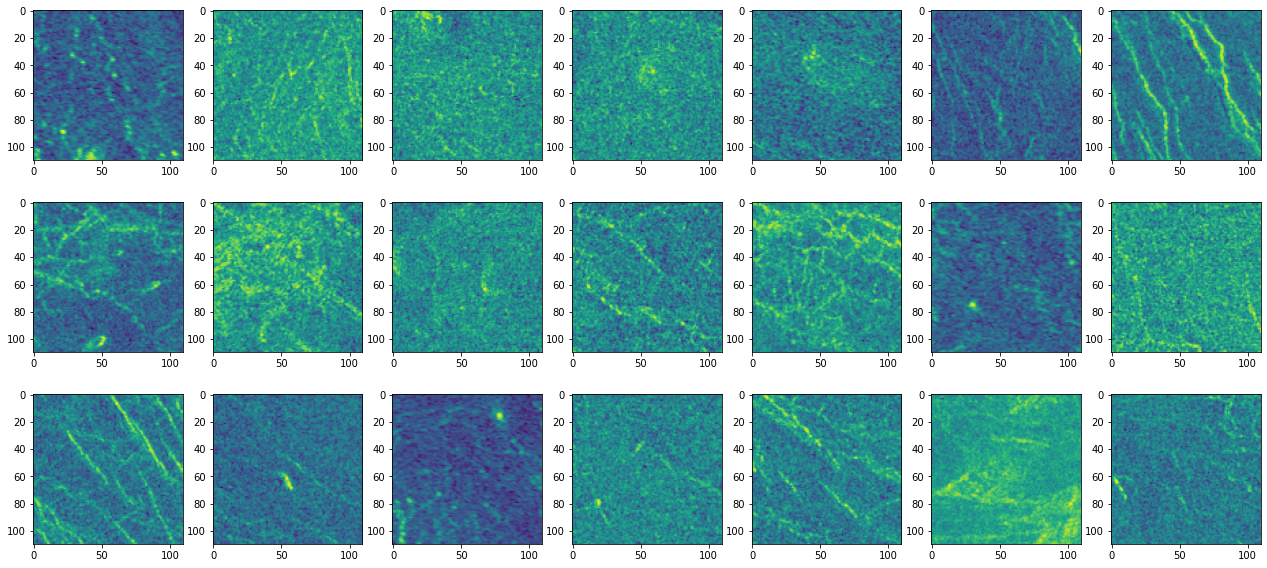

In [74]:
plt.figure(figsize = (22, 10))

for i in range(0, 21):
    subplot(3, 7, i+1)
    plt.imshow(non_vol[i].reshape(110, 110))

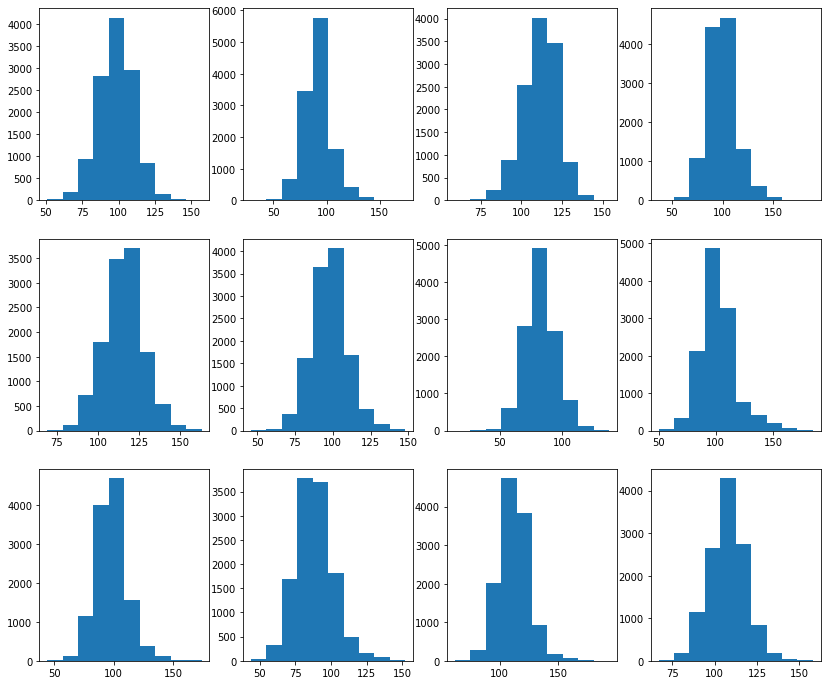

In [64]:
plt.figure(figsize = (14, 12))

for i in range(0, 12):
    subplot(3, 4, i+1)
    plt.hist(255*vol[i])
    #plt.title("Volcano" if df.iloc[i]["Volcano"] == 1 else "Not Volcano")

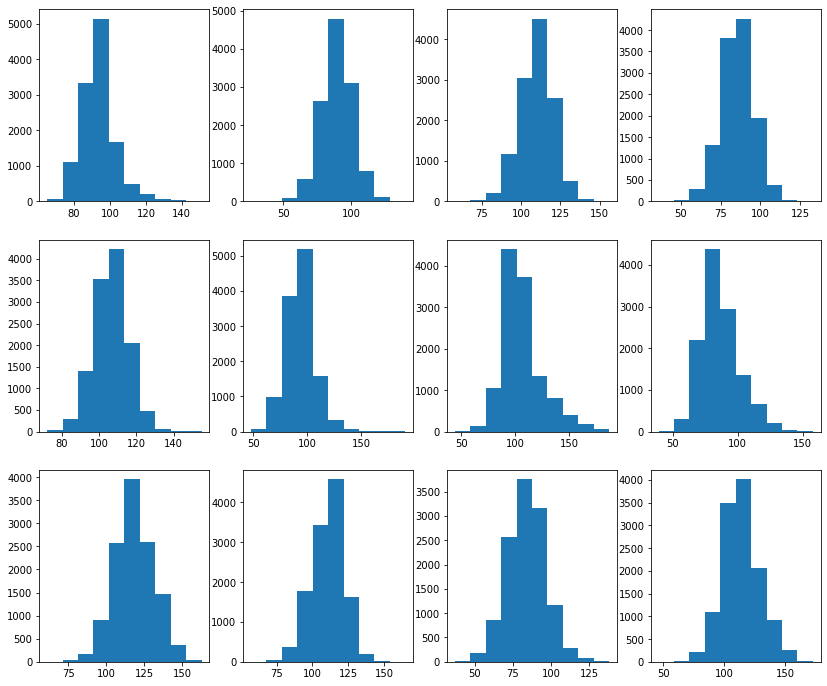

In [65]:
plt.figure(figsize = (14, 12))

for i in range(0, 12):
    subplot(3, 4, i+1)
    plt.hist(255*non_vol[i])
    #plt.title("Volcano" if df.iloc[i]["Volcano"] == 1 else "Not Volcano")